# Seizure detection with MNE-Features.

In this code, we try to compare multiple classification strategies in the MNE/scikit-learn toolboxes. 
The classifiers will use the open Bonn iEEG dataset, which consists of 300 iEEG samples
(200 are seizure-free segments and 100 correspond to ictal activity). The data
was recorded at 173.61Hz on a single channel.



In [1]:
import os
import os.path as op

from download import download

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import classification_report

from mne_features.feature_extraction import FeatureExtractor

print(__doc__)

c:\python\python36\lib\site-packages\mne_features\mock_numba.py:12: UserWarning: No module named 'numba'. Your code will be slower.
  warn('{}. Your code will be slower.'.format(err))


Automatically created module for IPython interactive environment


c:\python\python36\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


### Data preparation

First, we download the iEEG data from the Bonn dataset:

In [2]:
def download_bonn_ieeg(path, verbose=False):
    base_url = 'http://epileptologie-bonn.de/cms/upload/workgroup/lehnertz/'
    urls = [('setC', 'N.zip'), ('setD', 'F.zip'), ('setE', 'S.zip')]
    paths = list()
    for set_name, url_suffix in urls:
        _path = download(op.join(base_url, url_suffix),
                         op.join(path, set_name), kind='zip', replace=False,
                         verbose=verbose)
        paths.append(_path)
    return paths


# Download the data to ``./bonn_data``:
paths = download_bonn_ieeg('./bonn_data')

Next, we add labels to the data (0 = Seizure-free, 1 = Seizure).

'Segments in set D were recorded from within the epileptogenic zone, and those in set C from the hippocampal formation of the opposite hemisphere of the brain. While sets C and D contained only activity measured during seizure free intervals,
set E only contained seizure activity. Here segments were selected from all recording sites exhibiting ictal activity.'

(Andrzejak, Ralph & Lehnertz, Klaus & Mormann, Florian & Rieke, Christoph & David, Peter & Elger, Christian. (2002). Indications of nonlinear deterministic and finite-dimensional structures in time series of brain electrical activity: Dependence on recording region and brain state. Physical review. E, Statistical, nonlinear, and soft matter physics. 64. 061907. 10.1103/PhysRevE.64.061907)

In [3]:
data_segments = list()
labels = list()
sfreq = 173.61
for path in paths:
    fnames = [s for s in os.listdir(path) if s.lower().endswith('.txt')]
    for fname in fnames:
        _data = pd.read_csv(op.join(path, fname), sep='\n', header=None)
        data_segments.append(_data.values.T[None, ...])
    if 'setE' in path: # Then, it's seizure data
        labels.append(np.ones((len(fnames),)))
    else:
        labels.append(np.zeros((len(fnames),)))
        
data = np.concatenate(data_segments)
y = np.concatenate(labels, axis=0) 

# Shape of extracted data:
print(data.shape) # 300 recordings of 4097 datapoints
print(y.shape) # Label for each recording

(300, 1, 4097)
(300,)


Next, we choose the features that we will be tracking and our classification methods.

In [32]:
selected_funcs = ['line_length', 'kurtosis', 'ptp_amp', 'skewness']

skf = StratifiedKFold(n_splits=5)
seed = 26

names = ['Random Forest','K-Nearest Neighbours','Naive Bayes','Support Vector Machine']
classifiers = [RandomForestClassifier(n_estimators=100,max_depth=4,random_state=seed),KNeighborsClassifier(n_neighbors=10),GaussianNB(),SVC(kernel="linear",C=0.025,random_state=seed)]


### Results

In [33]:
for i in range(len(names)):
    pipe = Pipeline([('fe', FeatureExtractor(sfreq=sfreq,selected_funcs=selected_funcs)),('clf', classifiers[i])])
    scores = cross_val_score(pipe, data, y, cv=skf)
    print('=====================================================')
    print(names[i])
    print('scores =',list(np.around(np.array(scores),4)))
    print('Cross-validation accuracy score = %1.3f (+/- %1.5f)' % (np.mean(scores),np.std(scores)))
print('=====================================================')

Random Forest
scores = [0.9667, 0.95, 0.9667, 0.9833, 0.9833]
Cross-validation accuracy score = 0.970 (+/- 0.01247)
K-Nearest Neighbours
scores = [0.95, 0.9333, 0.9167, 0.9, 0.9]
Cross-validation accuracy score = 0.920 (+/- 0.01944)
Naive Bayes
scores = [0.9667, 0.95, 0.95, 0.95, 0.95]
Cross-validation accuracy score = 0.953 (+/- 0.00667)
Support Vector Machine
scores = [0.9667, 0.9667, 0.9667, 0.9833, 0.9833]
Cross-validation accuracy score = 0.973 (+/- 0.00816)


We compare the results by plotting the confusion matrices and the ROC curves.

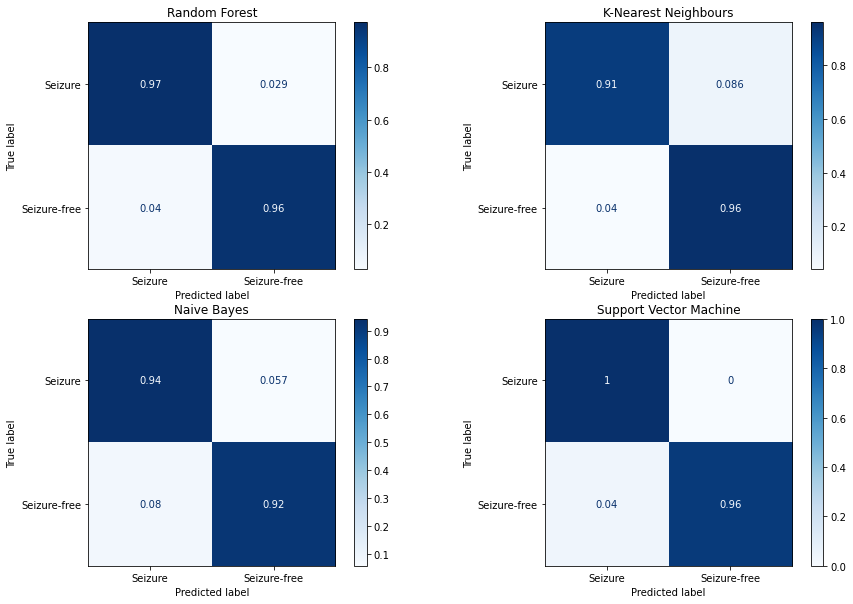

In [35]:
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2, random_state=26)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

for clf,ax,name in zip(classifiers, axes.flatten(),names):
    pipe = Pipeline([('fe', FeatureExtractor(sfreq=sfreq,selected_funcs=selected_funcs)),('clf', clf)])
    pipe.fit(X_train,y_train)

    plot_confusion_matrix(pipe, X_test, y_test,
                        display_labels=['Seizure','Seizure-free'],
                        cmap=plt.cm.Blues,
                        normalize='true',ax=ax)
    ax.title.set_text(name)
plt.show()

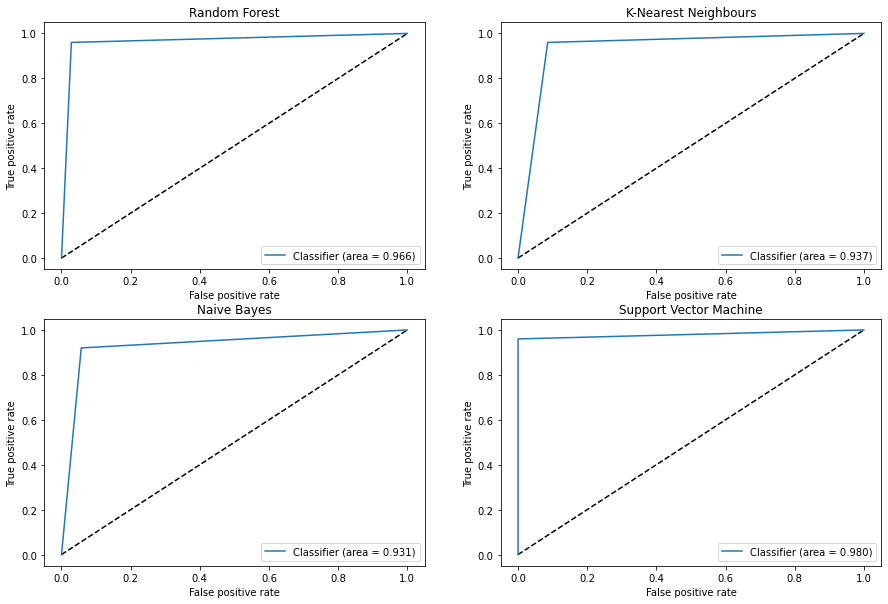

In [36]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

for clf, ax, name in zip(classifiers, axes.flatten(),names): 
    pipe = Pipeline([('fe', FeatureExtractor(sfreq=sfreq,selected_funcs=selected_funcs)),('clf', clf)])
    pipe.fit(X_train,y_train)
    y_pred = pipe.predict(X_test)

    fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred)
    auc_keras = auc(fpr_keras, tpr_keras)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.plot(fpr_keras, tpr_keras, label='Classifier (area = {:.3f})'.format(auc_keras))
    ax.set_xlabel('False positive rate')
    ax.set_ylabel('True positive rate')
    ax.set_title(name)
    ax.legend(loc='best')
    
plt.show()

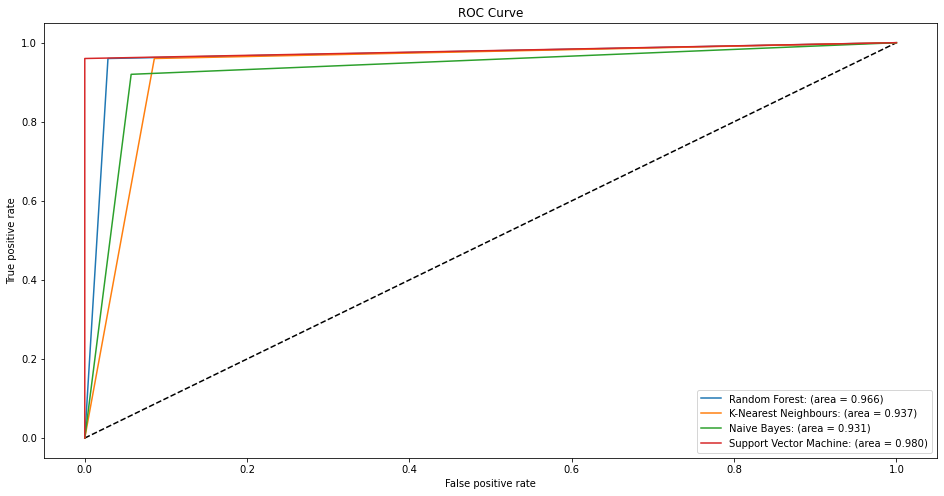

In [37]:
plt.figure(figsize=(16,8))
plt.plot([0, 1], [0, 1], 'k--')

for clf, name in zip(classifiers,names): 
    pipe = Pipeline([('fe', FeatureExtractor(sfreq=sfreq,selected_funcs=selected_funcs)),('clf', clf)])
    pipe.fit(X_train,y_train)
    y_pred = pipe.predict(X_test)

    fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred)
    auc_keras = auc(fpr_keras, tpr_keras)
    
    plt.plot(fpr_keras, tpr_keras, label=name+': (area = {:.3f})'.format(auc_keras))
    
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')    
plt.legend(loc='best')   
plt.title('ROC Curve')    
plt.show()

In [38]:
for i in range(len(names)): 
    pipe = Pipeline([('fe', FeatureExtractor(sfreq=sfreq,selected_funcs=selected_funcs)),('clf', classifiers[i])])
    pipe.fit(X_train,y_train)
    y_pred = pipe.predict(X_test)
    print('=====================================================')
    print(names[i])
    print()
    print(classification_report(y_test, y_pred, target_names=['Seizure','Seizure-Free']))
print('=====================================================')

Random Forest

              precision    recall  f1-score   support

     Seizure       0.97      0.97      0.97        35
Seizure-Free       0.96      0.96      0.96        25

    accuracy                           0.97        60
   macro avg       0.97      0.97      0.97        60
weighted avg       0.97      0.97      0.97        60

K-Nearest Neighbours

              precision    recall  f1-score   support

     Seizure       0.97      0.91      0.94        35
Seizure-Free       0.89      0.96      0.92        25

    accuracy                           0.93        60
   macro avg       0.93      0.94      0.93        60
weighted avg       0.94      0.93      0.93        60

Naive Bayes

              precision    recall  f1-score   support

     Seizure       0.94      0.94      0.94        35
Seizure-Free       0.92      0.92      0.92        25

    accuracy                           0.93        60
   macro avg       0.93      0.93      0.93        60
weighted avg       0.93 